# 1. Preprocessing

## 1.1 Import Libraries

In [21]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

## 1.2 Check images size

In [22]:
from PIL import Image
import os

img_shapes = []
root_dir = "G:\Projects\Cellula_Internship\Oral_Diseases_Classification\Teeth_Dataset\Training"

for class_dir in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_dir)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img_shapes.append(img.size)

# See unique image sizes
unique_sizes = set(img_shapes)
print(unique_sizes)

img_shapes = []
root_dir = "G:\Projects\Cellula_Internship\Oral_Diseases_Classification\Teeth_Dataset\Validation"

for class_dir in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_dir)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img_shapes.append(img.size)

# See unique image sizes
unique_sizes = set(img_shapes)
print(unique_sizes)

img_shapes = []
root_dir = "G:\Projects\Cellula_Internship\Oral_Diseases_Classification\Teeth_Dataset\Testing"

for class_dir in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_dir)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img_shapes.append(img.size)

# See unique image sizes
unique_sizes = set(img_shapes)
print(unique_sizes)


{(256, 256)}
{(256, 256)}
{(32, 32), (256, 256), (64, 64)}


### We now understand that Training and Validation images all are of same size but, there are some images in the test set which are of different size. We should take only the images of the 7 classes and neglect the "Output" folders (may be it represents the result of a previous model).

## 1.3 Import Dataset

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input

# ✅ Path settings
data_dir = "G:\Projects\Cellula_Internship\Oral_Diseases_Classification\Teeth_Dataset"

# ✅ Pretrained model image size (must be compatible with base model)
img_height = 224
img_width = 224
batch_size = 32
IMG_SIZE = (img_height, img_width)

# ✅ Use only known 7 class folders (ignore "output" folders)
class_names = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

# ✅ Load datasets with resizing and fixed label_mode for softmax
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{data_dir}/training",
    labels='inferred',
    label_mode='int',  
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{data_dir}/validation",
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{data_dir}/Testing",
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=False  # don't shuffle test set
)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


## 1.4 Display Sample of Raw Images

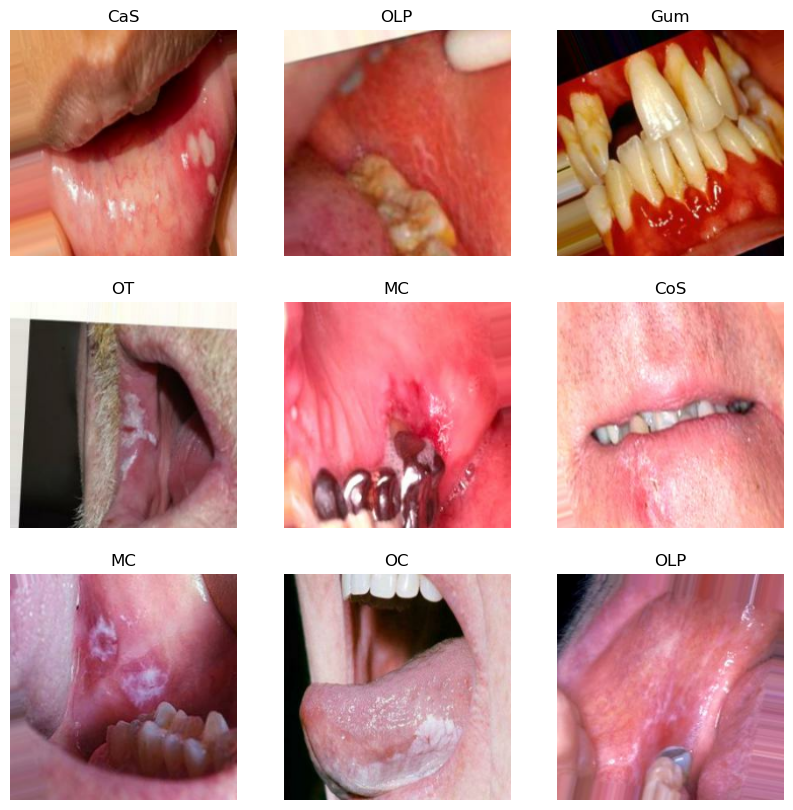

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 1.5 Augment Data

In [25]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),         # Flip horizontally
    tf.keras.layers.RandomRotation(0.1),              # Rotate ±25%
    tf.keras.layers.RandomZoom(0.1),                  # Slight zoom
    tf.keras.layers.RandomBrightness(factor=0.1),     # Slight brightness change
])

train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

## 1.6 Display Sample of Augmented Images

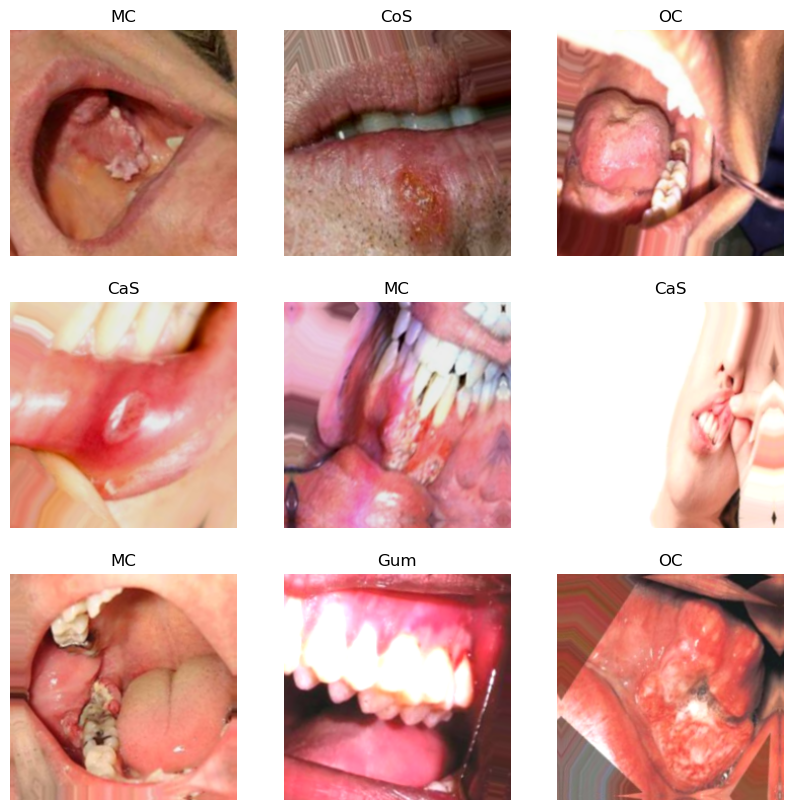

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 1.7 Combine Raw and Augmented Training Data

In [27]:
combined_train_ds = train_ds.concatenate(train_ds_aug)

In [28]:
total_images = 0
for images, labels in combined_train_ds:
    total_images += images.shape[0]  # number of images in the batch

print("✅ Total images in combined_train_ds:", total_images)

✅ Total images in combined_train_ds: 6174


## 1.8 Normalize Data

In [29]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_ds_norm = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds_norm = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds_norm = test_ds.map(lambda x, y: (preprocess_input(x), y))

### We normalized the original training data NOT the augmented training data as after various experiments we observed that data augmentation led to very bad model performance.

# 2. Visualization

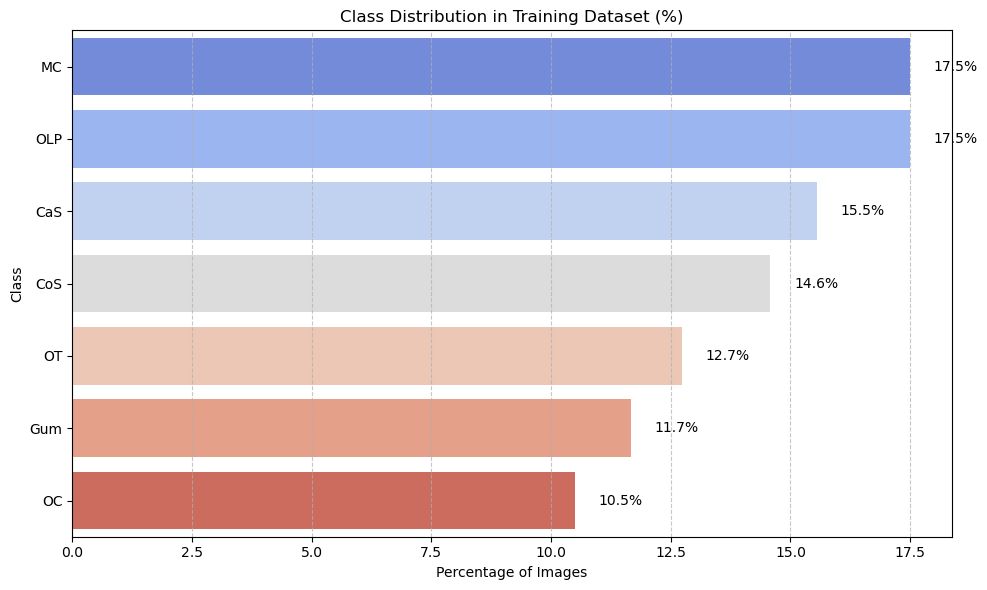

In [30]:
# Path to your training dataset
train_dir = "G:\Projects\Cellula_Internship\Oral_Diseases_Classification\Teeth_Dataset\Training"  

# Count images per class
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            file for file in os.listdir(class_path)
            if file.lower().endswith((".jpg", ".jpeg", ".png"))
        ])
        class_counts[class_name] = num_images

# Convert to DataFrame
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
total_images = df["Image Count"].sum()
df["Percentage"] = (df["Image Count"] / total_images) * 100
df = df.sort_values("Percentage", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Percentage", y="Class", data=df, palette="coolwarm")

# Add percentage labels on bars
for i, p in enumerate(barplot.patches):
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    barplot.text(width + 0.5, y, f'{df["Percentage"].iloc[i]:.1f}%', va='center')

# Styling
plt.title("Class Distribution in Training Dataset (%)")
plt.xlabel("Percentage of Images")
plt.ylabel("Class")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### This level of imbalance does NOT require urgent action may be class weights can be used later in model training.

# 3. Model Building

## 3.1 Define Model Architecture

In [31]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

# Add custom head
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Used GAP instead of Flatten to reduce the number of parameters and improve model performance.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_pretrained_model.keras',
    monitor='val_accuracy',   
    save_best_only=True,
    verbose=1
)

In [33]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 3.2 Define Class Weights

In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# Assume your training directory structure is already sorted
train_dir = "G:\Projects\Cellula_Internship\Oral_Diseases_Classification\Teeth_Dataset\Training"
class_names = sorted(os.listdir(train_dir))  # should match model class order

# Build full label list
y_labels = []
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    num_images = len([
        file for file in os.listdir(class_path)
        if file.lower().endswith((".jpg", ".jpeg", ".png"))
    ])
    y_labels.extend([idx] * num_images)

# Compute weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)

# Convert to dict
class_weights = dict(enumerate(class_weights_array))
print("✅ Class weights:", class_weights)

✅ Class weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


## 3.3 Model Training

```python

### After various experiments data augmentation is NOT used in training as it was not improving the model performance. so, we will use the original training data.
```

In [35]:
history = model.fit(
    train_ds_norm,
    validation_data=val_ds_norm,
    epochs=20,
    callbacks=[checkpoint],
    class_weight=class_weights 
)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4462 - loss: 1.4839
Epoch 1: val_accuracy improved from -inf to 0.74708, saving model to best_pretrained_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.4474 - loss: 1.4811 - val_accuracy: 0.7471 - val_loss: 0.7737
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7309 - loss: 0.7694
Epoch 2: val_accuracy improved from 0.74708 to 0.84728, saving model to best_pretrained_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.7311 - loss: 0.7689 - val_accuracy: 0.8473 - val_loss: 0.5311
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8286 - loss: 0.5213
Epoch 3: val_accuracy improved from 0.84728 to 0.90661, saving model to best_pretrained_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.8286 - loss: 0.5213 - val_accuracy: 0.9066 - val_loss: 0.3539
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8591 - loss: 0.4178
Epoch 4: val_accuracy i

## 3.4 Model Evaluation

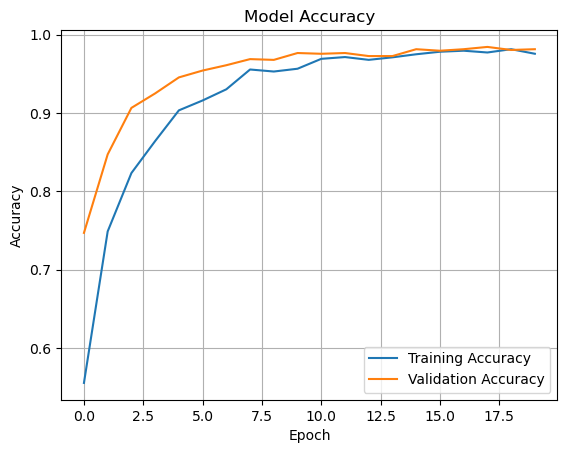

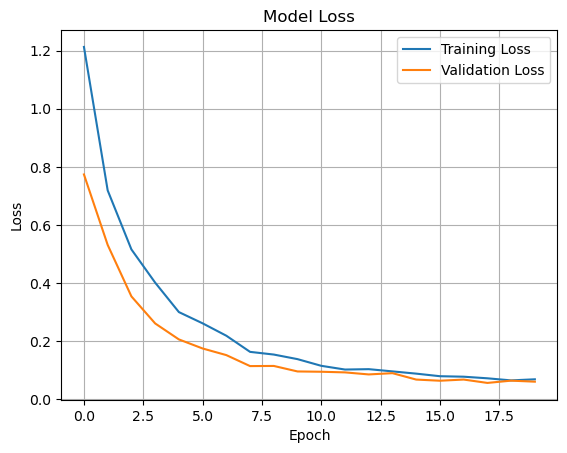

In [36]:
# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
test_loss, test_accuracy = model.evaluate(test_ds_norm)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9874 - loss: 0.0465
✅ Test Accuracy: 0.9854
📉 Test Loss: 0.0559


In [38]:
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds_norm:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━

<Figure size 800x600 with 0 Axes>

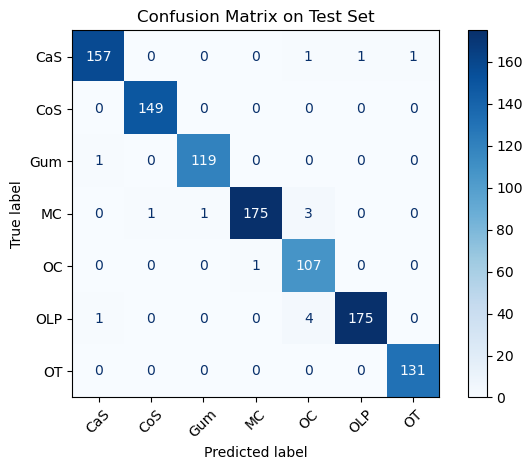

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate matrix
cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names  # assumes same order

# Plot
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()